# Application of Gaussian Process on Images Classification Task

In [1]:
import time
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

2023-12-31 20:45:01.438741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fashion MNIST Dataset Preprocess

In [6]:
# Dataset name
dataset_name = "fashion_mnist"

# Load Fashion MNIST Dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = fashion_mnist.load_data()

# Labels are selected labels we use
labels = [1, 2, 3, 4]

# filter datasets with selected labels
train_filter = np.isin(y_train_full, labels)
test_filter = np.isin(y_test_full, labels)

x_train, y_train = x_train_full[train_filter], y_train_full[train_filter]
x_test, y_test = x_test_full[test_filter], y_test_full[test_filter]

# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

#reshape image into 1-dimension
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Collect all dataset
x_all = np.concatenate((x_train, x_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# randomly select n images as dataset for training and validation
idx = np.random.choice(np.arange(x_train.shape[0]),160, replace=False)
x_train, y_train = x_train[idx], y_train[idx]

# Splite dataset into training and validating
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)



## Cifar-10 Dataset Preprocess

In [4]:
# Dataset Name
dataset_name = "cifar_10"

# Load CIFAR-10 Dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

# Labels are selected labels we use
labels = [1, 2, 3, 4]

# flatten labels
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()

# filter datasets with selected labels
train_filter = np.isin(y_train_full, labels)
test_filter = np.isin(y_test_full, labels)

x_train, y_train = x_train_full[train_filter], y_train_full[train_filter]
x_test, y_test = x_test_full[test_filter], y_test_full[test_filter]

# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

#reshape image into 1-dimension
x_train = x_train.reshape(-1, 32*32*3)  # CIFAR-10 images are 32x32 and 3-channel (RGB)
x_test = x_test.reshape(-1, 32*32*3)

# Collect all dataset which classes are in labels
x_all = np.concatenate((x_train, x_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# randomly select 200 images as dataset for training and validation
idx = np.random.choice(np.arange(x_train.shape[0]), 200, replace=False)
x_train, y_train = x_train[idx], y_train[idx]

# Split dataset into training and validating
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

## Fit Gaussian process classification model

In [7]:
# Record starting time
start_time = time.time()

# Execution fitting model
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(x_train, y_train)

# Record ending time 
end_time = time.time()

# Calculate fitting time
execution_time = end_time - start_time
print("Execution Time on fitting GP classifier: ", execution_time, "seconds")

# Calculating the accuracy on validation dataset
accuracy = gpc.score(x_val, y_val)
print("Validation accuracy on validation dataset: ", accuracy)

# Calculating the accuracy on all dataset which classes are only 0 or 1
accuracy_all = gpc.score(x_all, y_all)
print("Accuracy on all dataset: ", accuracy_all)

# Prediction on validation dataset
y_pred = gpc.predict(x_val)

Execution Time on fitting GP classifier:  0.9249813556671143 seconds
Validation accuracy on validation dataset:  0.8958333333333334
Accuracy on all dataset:  0.8279285714285715


## Plot GP Classifier results on validation dataset

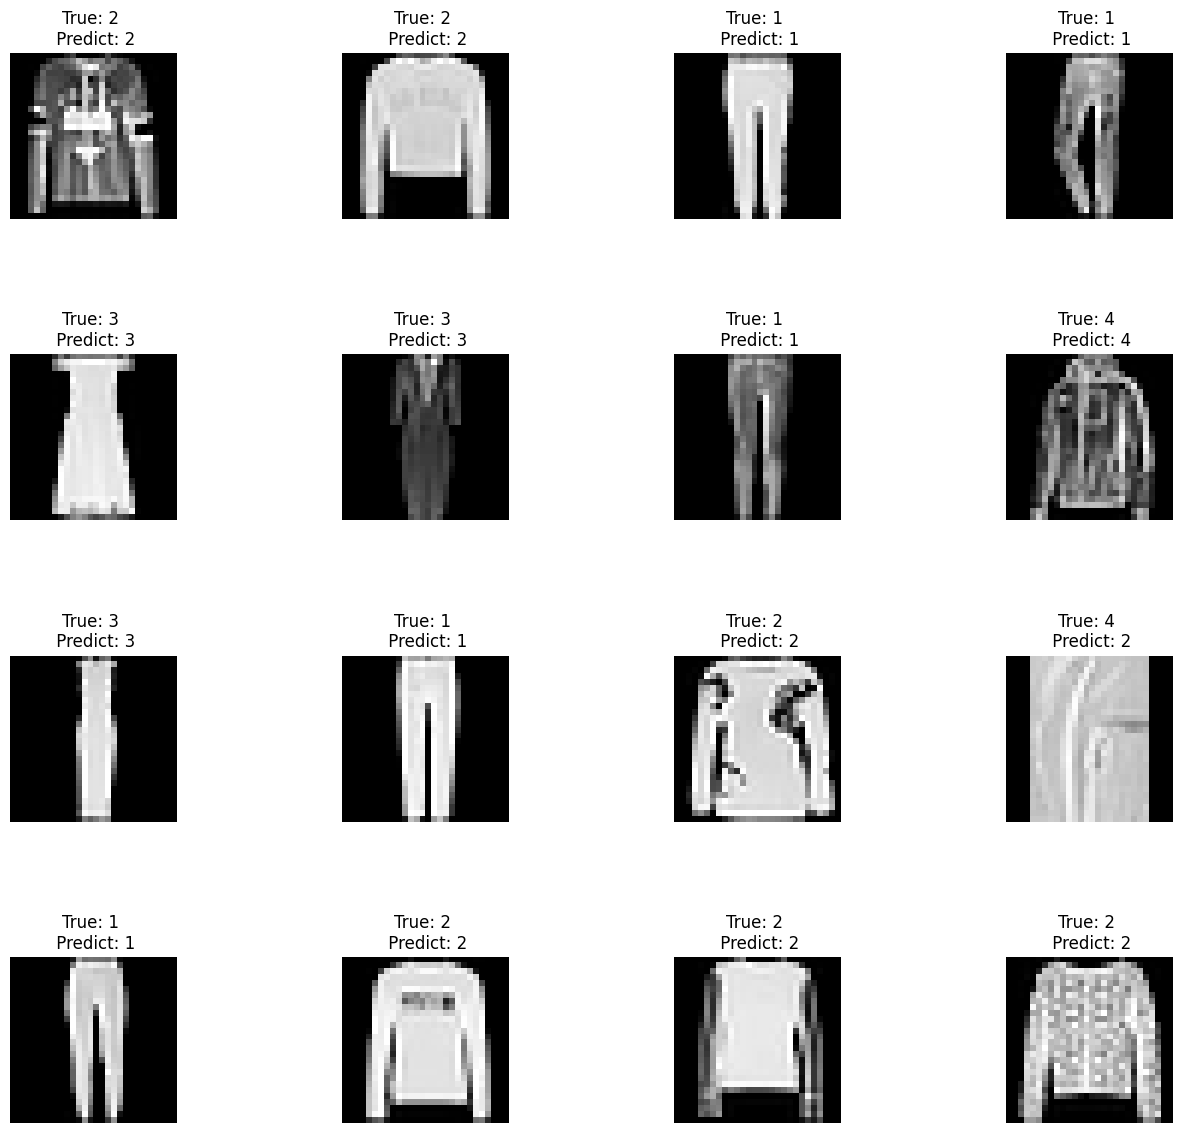

In [8]:
# Plot the results on validation dataset
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.ravel()
    
for i in np.arange(0, 16):  
    if dataset_name == "fashion_mnist":
        axes[i].imshow(x_val[i].reshape(28,28), cmap='gray')
    elif dataset_name == "cifar_10":
        axes[i].imshow(x_val[i].reshape(32,32,3))
    else:
        "invalid dataset name"
    axes[i].set_title("True: %s \n Predict: %s" % (y_val[i], y_pred[i]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

plt.show()

### Give the uncertainty for each prediction

In [10]:
y_proba = gpc.predict_proba(x_val[:20,:])

# Each row corresponds to a sample, and each column corresponds to a class. 
# The values in the matrix represent the predicted probabilities 
# of the corresponding samples belonging to the respective classes.
print(y_proba)

[[0.16591635 0.34299508 0.15607847 0.3350101 ]
 [0.2111829  0.50106688 0.09392642 0.1938238 ]
 [0.66271621 0.0351917  0.26672599 0.0353661 ]
 [0.67216719 0.04040718 0.19129557 0.09613006]
 [0.21573438 0.07013509 0.61540232 0.09872821]
 [0.3583834  0.07382415 0.42345278 0.14433967]
 [0.74154237 0.0618241  0.1512028  0.04543073]
 [0.183757   0.21185476 0.14576956 0.45861868]
 [0.36418363 0.10031933 0.40133277 0.13416428]
 [0.70280502 0.04091249 0.22130978 0.03497271]
 [0.20378086 0.4238558  0.23603573 0.13632761]
 [0.14817719 0.49919423 0.23695118 0.1156774 ]
 [0.81653566 0.03979819 0.08922086 0.05444529]
 [0.13673408 0.66722199 0.09593027 0.10011366]
 [0.23468584 0.38622143 0.17301954 0.20607319]
 [0.17372265 0.52704362 0.13378147 0.16545226]
 [0.85903763 0.03817984 0.06602345 0.03675907]
 [0.10253307 0.05478699 0.72678081 0.11589912]
 [0.67829181 0.05430478 0.16207754 0.10532587]
 [0.83117058 0.03248048 0.09618096 0.04016797]]


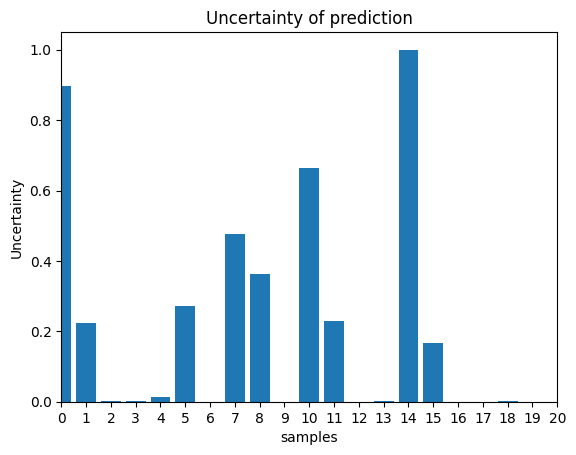

In [11]:
# Calculate variances of classification probability
variances = np.var(y_proba, axis=1)

# Evaluate the uncertainty of the prediction
# Scale factor: 10
# Increase the gap between different uncertanties.
uncertainties = (1 - (variances - np.min(variances)) / (np.max(variances) - np.min(variances))) ** 10

# Set the limits of x-axis
plt.xlim(0, 20)

# Set the ticks of x-axis
plt.xticks(range(0, 21))  

# Visualize the uncertainties
plt.bar(range(len(uncertainties)), uncertainties)
plt.xlabel('samples')
plt.ylabel('Uncertainty')
plt.title('Uncertainty of prediction')
plt.show()

## Introduce abnormal/new data which model has never seen

In [12]:
x_abnormal, y_abnormal = x_test_full[1000:1100], y_test_full[1000:1100]

x_abnormal = x_abnormal / 255.0

x_abnormal = x_abnormal.reshape(-1, 28*28)

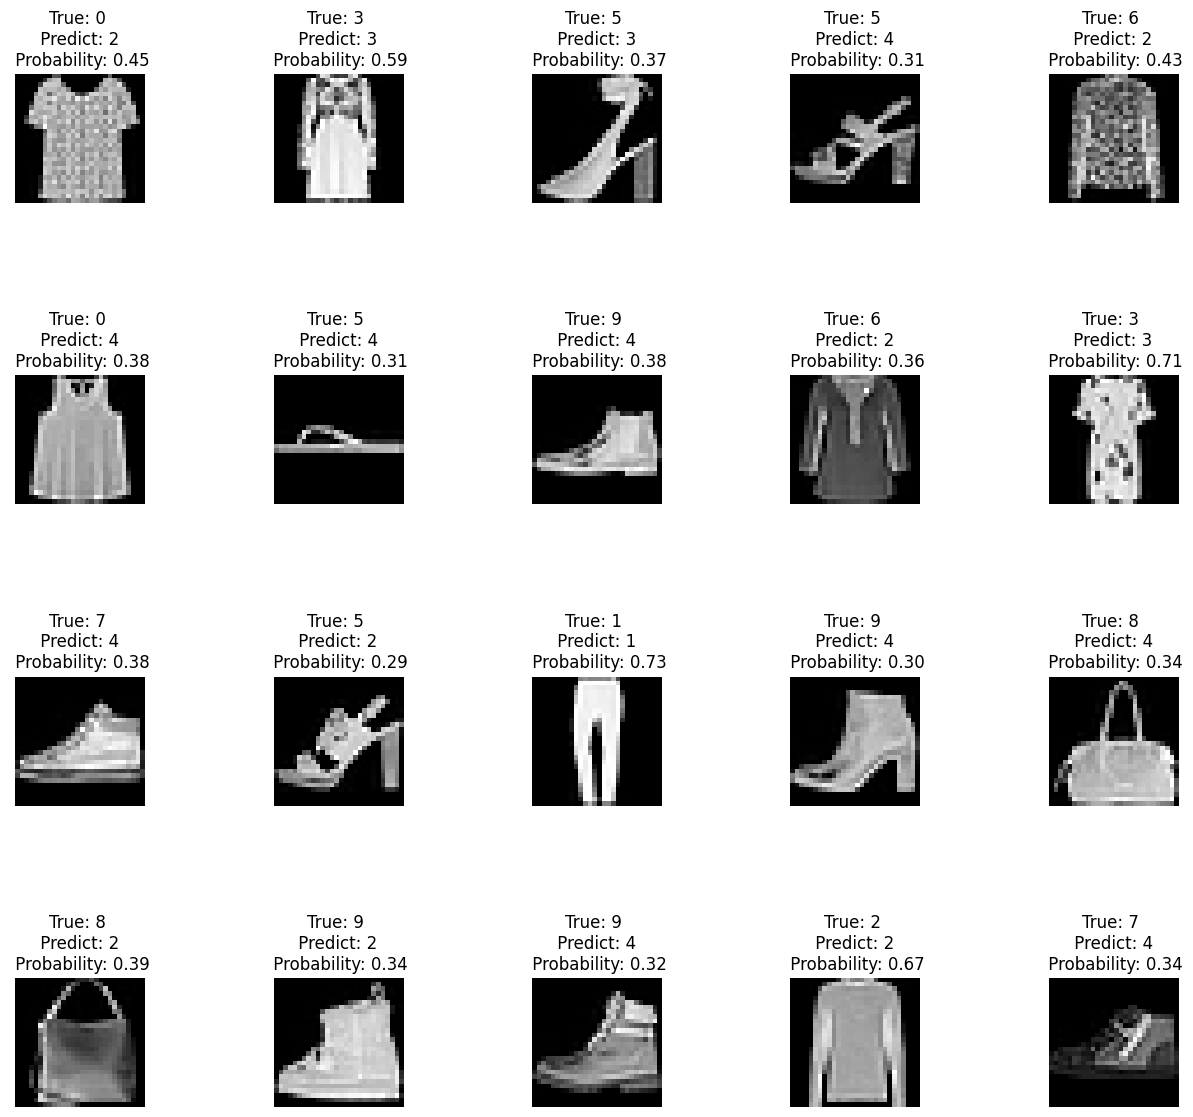

In [13]:
y_pred_abnormal = gpc.predict(x_abnormal)
y_proba = gpc.predict_proba(x_abnormal)

fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, 20):  
    axes[i].imshow(x_abnormal[i].reshape(28,28), cmap='gray')
    axes[i].set_title("True: %s \n Predict: %s \n Probability: %.2f" % (y_abnormal[i], y_pred_abnormal[i], np.max(y_proba[i])))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

plt.show()

### Visualize the uncertainties

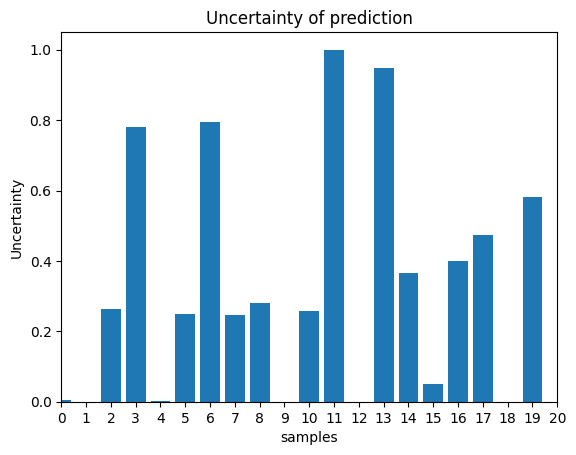

In [14]:
y_pred_abnormal = gpc.predict(x_abnormal[:20,:])
y_proba = gpc.predict_proba(x_abnormal[:20,:])

# Calculate variances of classification probability
variances = np.var(y_proba, axis=1)

# Evaluate the uncertainty of the prediction
# Scale factor: 10
# Increase the gap between different uncertanties.
uncertainties = (1 - (variances - np.min(variances)) / (np.max(variances) - np.min(variances))) ** 20

# Set the limits of x-axis
plt.xlim(0, 20)

# Set the ticks of x-axis
plt.xticks(range(0, 21))  

# Visualize the uncertainties
plt.bar(range(len(uncertainties)), uncertainties)
plt.xlabel('samples')
plt.ylabel('Uncertainty')
plt.title('Uncertainty of prediction')
plt.show()

### Prediction on all dataset.(But only contains classes the model has seen)

In [15]:
# Prediction on all dataset
y_pred_all = gpc.predict(x_all)

### Visualization of Multi-Class Confusion Matrix

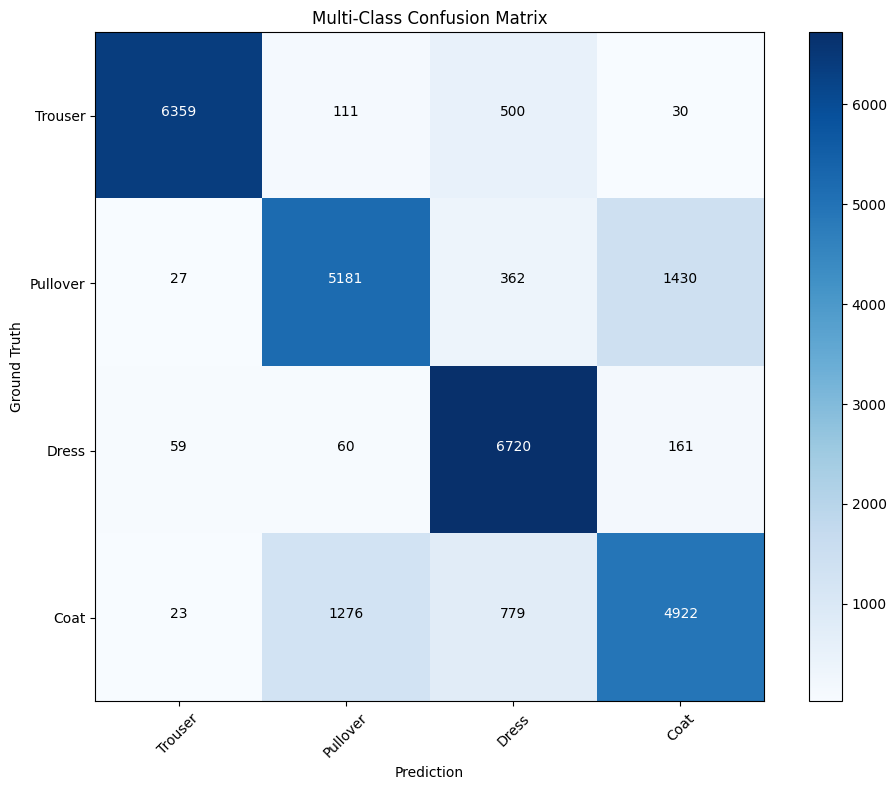

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# The Name of the labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# calculate confusion matrix
cm = confusion_matrix(y_all, y_pred_all)

plt.figure(figsize=(10, 8))

# plot
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Sort the labels. eg. [0, 4, 3, 1] -> [0, 1, 3, 4]
# Because the order of the confusion matrix is determined based on 
# the occurrence order of the unique class labels.
sorted_labels = sorted(labels)

# get labels of fashion mnist
class_names_partial = [class_names[label] for label in sorted_labels]

tick_marks = np.arange(len(class_names_partial))
plt.xticks(tick_marks, class_names_partial, rotation=45)
plt.yticks(tick_marks, class_names_partial)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Multi-Class Confusion Matrix')

thresh = cm.max() / 2
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()

plt.savefig('../results/Partial_Confusion_Matrix.png', dpi=200)

plt.show()

In [ ]:
#|       | high_uncertainty | low_uncertainty |
#|-------|------------------|-----------------|
#|correct|                  |                 |
#|-------|------------------|-----------------|
#| false |                  |                 |

# Goal: 
# 1. if we get low uncertainty, the predition should be as true as possible.
# 2. If we get high uncertainty, we could accept a false prediction.

### Calculate Uncertainty on all dataset which only contains selected labels

In [19]:
def calculate_accuracy(y_prediction, y_true):
    correct_predictions = 0
    total_predictions = len(y_true)

    for pred, true in zip(y_prediction, y_true):
        if pred == true:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [20]:
y_pred_all = gpc.predict(x_all)
y_proba_all = gpc.predict_proba(x_all)

In [21]:
# Calculate variances of classification probability
variances = np.var(y_proba_all, axis=1)
uncertainties = (1 - (variances - np.min(variances)) / (np.max(variances) - np.min(variances))) ** 20

In [22]:
### Only select prediction with uncertainty lower than threshold
threshold_uncertain = 0.01

y_pred_all_low_uncertain = y_pred_all[uncertainties < threshold_uncertain]
y_all_low_uncertain = y_all[uncertainties < threshold_uncertain]

accuracy_low_uncertain = calculate_accuracy(y_pred_all_low_uncertain, y_all_low_uncertain)

print("Accuracy on all prediction with low uncertainty: ", accuracy_low_uncertain)


Accuracy on all prediction with low uncertainty:  0.9223458646616541


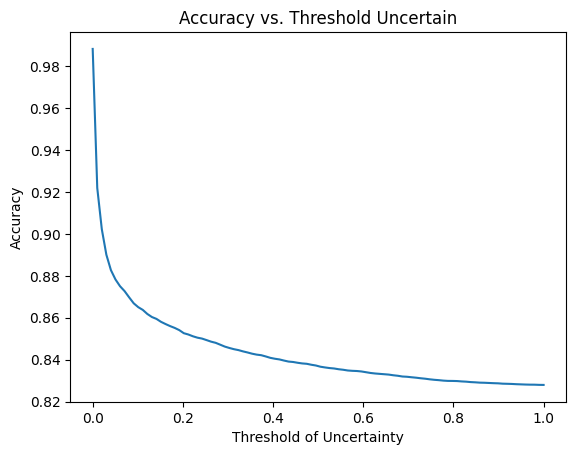

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# define different threshold_uncertain range
threshold_uncertain_values = np.linspace(0.0001, 1, 100)

accuracy_low_uncertain_values = []

# calculate accuracy_low_uncertain
for threshold_uncertain in threshold_uncertain_values:
    y_pred_all_low_uncertain = y_pred_all[uncertainties < threshold_uncertain]
    y_all_low_uncertain = y_all[uncertainties < threshold_uncertain]
    accuracy_low_uncertain = calculate_accuracy(y_pred_all_low_uncertain, y_all_low_uncertain)
    accuracy_low_uncertain_values.append(accuracy_low_uncertain)

# plot
plt.plot(threshold_uncertain_values, accuracy_low_uncertain_values)
plt.xlabel('Threshold of Uncertainty')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold Uncertain')

plt.savefig('../results/Accuracy_vs_Uncertainty.png', dpi=200)
plt.show()

### Conclusion

**From the above figure: "Accuracy vs. Threshold of low uncertain", we could set different threshold of uncertain to get different reliability of our model. 
When we set a lower threshold uncertainty, which means we have high requirements for the accuracy of the model, so accuracy of prediction with low uncertainty will be higher.**